In [1]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

import matplotlib as mpl  
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')


import torch.nn.functional as F
from utilities3 import *

class MyNet(torch.nn.Module):
    def __init__(self, s, width=32, rank=1):
        super(MyNet, self).__init__()
        self.s = s
        self.width = width
        self.rank = rank

        self.fc0 = nn.Linear(3, self.width)

        self.net1 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net2 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net3 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.net4 = LowRank2d(self.width, self.width, s, width, rank=self.rank)
        self.w1 = nn.Linear(self.width, self.width)
        self.w2 = nn.Linear(self.width, self.width)
        self.w3 = nn.Linear(self.width, self.width)
        self.w4 = nn.Linear(self.width, self.width)

        self.bn1 = torch.nn.BatchNorm1d(self.width)
        self.bn2 = torch.nn.BatchNorm1d(self.width)
        self.bn3 = torch.nn.BatchNorm1d(self.width)
        self.bn4 = torch.nn.BatchNorm1d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)


    def forward(self, v):
        batch_size, n = v.shape[0], v.shape[1]
        a = v.clone()

        v = self.fc0(v)

        v1 = self.net1(v, a)
        v2 = self.w1(v)
        v = v1+v2
        v = self.bn1(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net2(v, a)
        v2 = self.w2(v)
        v = v1+v2
        v = self.bn2(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net3(v, a)
        v2 = self.w3(v)
        v = v1+v2
        v = self.bn3(v.reshape(-1, self.width)).view(batch_size,n,self.width)
        v = F.relu(v)

        v1 = self.net4(v, a)
        v2 = self.w4(v)
        v = v1+v2
        v = self.bn4(v.reshape(-1, self.width)).view(batch_size,n,self.width)


        v = self.fc1(v)
        v = F.relu(v)
        v = self.fc2(v)

        return v.squeeze()

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c


class LowRank2d(nn.Module):
    def __init__(self, in_channels, out_channels, s, width, rank):
        super(LowRank2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.s = s
        self.n = s*s
        self.rank = rank

        self.phi = DenseNet([3, 64, 128, 256, width*width*rank], torch.nn.ReLU)
        self.psi = DenseNet([3, 64, 128, 256, width*width*rank], torch.nn.ReLU)


    def forward(self, v, a):
        # a (batch, n, 3)
        # v (batch, n, f)
        batch_size = v.shape[0]

        phi_eval = self.phi(a).reshape(batch_size, self.n, self.out_channels, self.in_channels, self.rank)
        psi_eval = self.psi(a).reshape(batch_size, self.n, self.out_channels, self.in_channels, self.rank)

        # print(psi_eval.shape, v.shape, phi_eval.shape)
        v = torch.einsum('bnoir,bni,bmoir->bmo', psi_eval, v, phi_eval) / self.n

        return v



In [2]:
model = torch.load('darcy2d_trained').cpu()


In [3]:
def calcSeg(startH, endH, endV, val1: float, val2: float, val3: float):
    X = np.ones((85, 85), dtype=float) * -1.
    deltaV = (val1 - val3) / (endH - startH)
    # deltaV = 0.

    for ix in range(startH, endH+1):
        val1 -= deltaV
        val1save = val1
        deltaH = (val1 - val2) / (endH - ix + 1)
        # deltaH = 0.
        for iy in range(endV+1):
            if ix < iy:
                X[ix, iy] = val1
                val1 -= deltaH 
        val1 = val1save
    return X

def flipSeg1(X, startH, endH, endV, val: float):
    boundR = 2*endH
    for ix in range(startH, endH+1):
        for iy in range(endV+1):
            if ix < iy:
                X[iy, boundR - ix] = X[ix, iy]

                X[boundR - ix, boundR - iy] = X[ix, iy]

                # X[boundR - ix, iy] = X[ix, iy]
                X[boundR - iy, ix] = X[ix, iy]

            # X[iy, ix] = X[ix, iy] if ix != iy else val
    return X

def calcPolar(cx, cy, initA: float, val1: float, val2: float, segments):
    X = np.ones((85, 85), dtype=float) * -1.
    for ix in range(85):
        for iy in range(85):
            (dx, dy) = (cx - ix, cy - iy)
            if dx == 0 and dy == 0:
                X[ix, iy] = val2
                continue
            if dx == 0:
                angle = np.pi/2 if dy > 0 else 3*np.pi/2
            else:
                angle = np.arctan2(dy, dx)

            angle = np.mod(angle*segments, 2*np.pi)

            X[ix, iy] = angle/np.pi - 1.

    return X

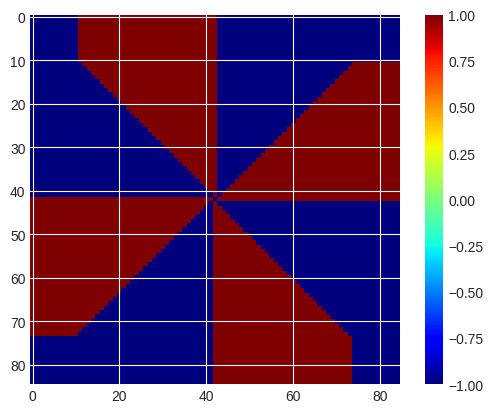

In [4]:
X = calcSeg(0, 42, 42, -1., 1., 1.)
X = flipSeg1(X, 0, 42, 42, -1.)

X = np.rint(X)
indices = np.where(X == 0) 
X[indices] += 1. 

plt.imshow(X, cmap='jet')
plt.colorbar()

torch.Size([1, 7225, 3])


torch.Size([7225])

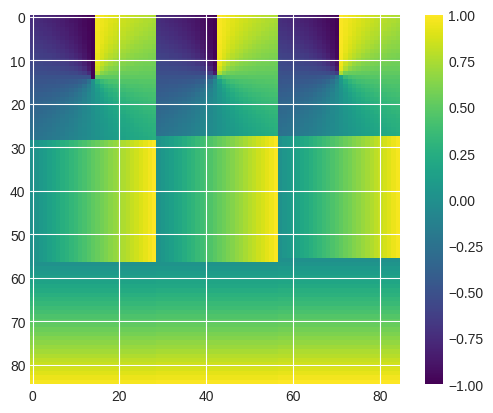

In [8]:
X, Y = torch.meshgrid((torch.linspace(0, 1, 85), torch.linspace(0, 1, 85)))

x1 = torch.tensor(calcPolar(42, 42, np.pi/4, 1., -1., 1), dtype=torch.float).reshape(-1) 
x1 = torch.vstack((x1, Y.reshape(-1), X.reshape(-1))).reshape(1, 7225, 3)

print(x1.shape)
plt.imshow(x1[0, :, 0].reshape(85, 85), cmap='viridis')
plt.colorbar(fraction=0.045)


x2 = torch.tensor(calcPolar(22, 32, np.pi/4, 1., -1., 1), dtype=torch.float).reshape(-1) 
x2 = torch.vstack((x2, Y.reshape(-1), X.reshape(-1))).reshape(1, 7225, 3)

# X = calcSeg(0, 42, 42, -1., 1., 1.)
# X = flipSeg1(X, 0, 42, 42, -1.)
# X = torch.tensor(X, dtype=torch.float).reshape(-1)
# X = torch.vstack((X,  Y.reshape(-1), X.reshape(-1))).reshape(1, 7225, 3)

# print(x1.shape, x2.shape)
# X  = torch.vstack((x1, x2))

# print(X.shape, X.dtype)

# X = calcSeg(0, 42, 42, -1., 1., 1.)
# X = flipSeg1(X, 0, 42, 42, -1.)
# 
# X = np.rint(X)
# indices = np.where(X == 0) 
# X[indices] += 1. 
# 
# # X = torch.tensor(X, dtype=torch.float).reshape(-1)
# X = torch.vstack((X,  Y.reshape(-1), X.reshape(-1))).reshape(1, 7225, 3)

model_output = model(x1).cpu() 

model_output.shape

torch.Size([1, 7225, 3])
(81, 81)


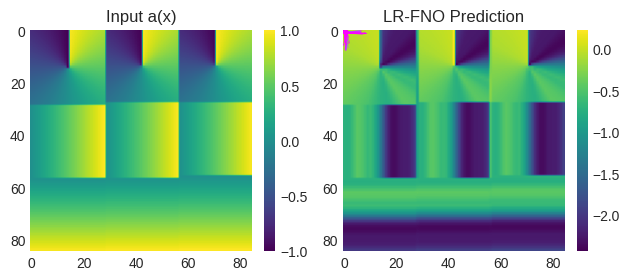

In [6]:
plt.subplot(121)
# X = calcSeg(0, 42, 42, -1., 1., 1.)
# Xdomain = flipSeg1(X, 0, 42, 42, -1.)

# X = calcSeg(0, 42, 42, -1., 1., 1.)
# X = flipSeg1(X, 0, 42, 42, -1.)
# 
# X = np.rint(X)
# indices = np.where(X == 0) 
# X[indices] += 1. 
# print(X.shape, X.squeeze().shape)
# Xdomain = X.squeeze()[:, 0].reshape(85, 85)
print(x2.shape)
plt.imshow(x1[0, :, 0].reshape(85, 85), cmap='viridis')
plt.colorbar(fraction=0.045)

plt.title("Input " + r"a(x)")

plt.grid(False)


ax2 = plt.subplot(122)
out = model_output.reshape(85, 85)
plt.imshow(model_output.reshape(85, 85).detach().numpy(), cmap='viridis')
plt.colorbar(fraction=0.045)
plt.grid(False)

X, Y = torch.meshgrid(torch.linspace(0, 1, 85), torch.linspace(0, 1, 85))

Ux = -torch.diff(out, dim=0, prepend=torch.zeros(1, 85))
Uy = torch.diff(out, dim=1, prepend=torch.zeros(85, 1))

N = 2

X, Y, Ux, Uy = X[2:-2,2:-2], Y[2:-2,2:-2], Ux[2:-2,2:-2], Uy[2:-2,2:-2]

C = Ux**2 + Uy**2

coloring = lambda x, y: x**2 + y**2
colors = coloring(Ux, Uy).cpu().detach().numpy()
norm  = mpl.colors.Normalize()
norm.autoscale(colors)
cmap = mpl.cm.cool_r
print(norm(colors).shape)

ax2.quiver(Y[::N, ::N], X[::N, ::N], Uy[::N, ::N].flip(0).cpu().detach().numpy(), Ux[::N, ::N].flip(0).cpu().detach().numpy(), C[::N, ::N].cpu().detach().numpy(),  pivot='mid', units='xy', cmap=cmap, norm=norm) # , pivot='mid',units='x'

plt.title("LR-FNO Prediction")

plt.tight_layout()

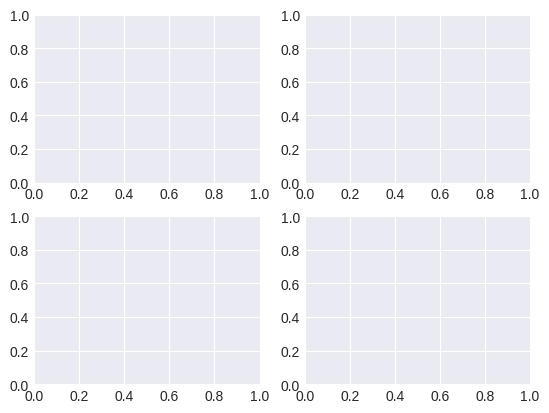

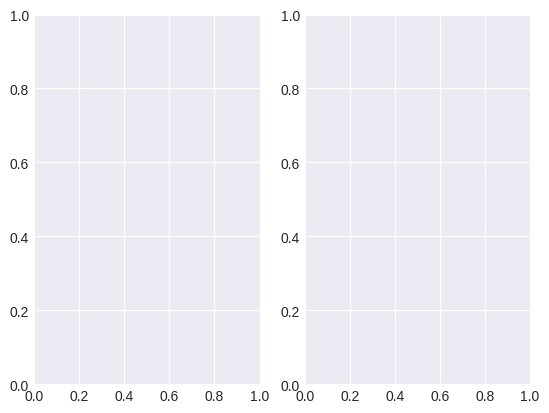

In [7]:

# X = np.random.uniform(low=-1., high=1., size=(85, 85))
# fig, axs = plt.subplots(2, 2)

X = calcPolar(42, 42, np.pi/4, 1., -1., 1)
# fig.colorbar(axs[0,0].imshow(X))


X = calcPolar(22, 32, np.pi/4, 1., -1., 1)
# fig.colorbar(axs[0,1].imshow(X))


X = calcPolar(42, 42, np.pi/4, 1., -1., 2)
# fig.colorbar(axs[1,0].imshow(X))

X = calcPolar(22, 32, np.pi/4, 1., -1., 2)
# fig.colorbar(axs[1,1].imshow(X))


fig, axs = plt.subplots(2, 2)

X = calcPolar(42, 42, np.pi/4, 1., -1., 3)
# fig.colorbar(axs[0,0].imshow(X))

X = calcPolar(22, 32, np.pi/4, 1., -1., 3)
# fig.colorbar(axs[0,1].imshow(X))

X = calcPolar(42, 42, np.pi/4, 1., -1., 5)
# fig.colorbar(axs[1,0].imshow(X))
# 
X = calcPolar(22, 32, np.pi/4, 1., -1., 5)
# fig.colorbar(axs[1,1].imshow(X))


fig, (ax1, ax2) = plt.subplots(1, 2)
X = calcSeg(0, 42, 42, 1., -1., -1.)
X = flipSeg1(X, 0, 42, 42, -1.)
# fig.colorbar(ax1.imshow(X))

X = calcSeg(0, 42, 42, -1., 1., 1.)
X = flipSeg1(X, 0, 42, 42, -1.)
# fig.colorbar(ax2.imshow(X))